# Выполнено Зверьковой Елизаветой Алексеевной

# Сессия 4

## В данной сессии нам необходимо: 
- разработать прогнозную модель для определения категории новой жалобы
- подобрать алгоритм прогнозирования в результате сравнения нескольких вариантов и оценить точность их работы

In [2]:
# Импорты
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score
import seaborn as sns 
import re
# saving
import pickle

In [5]:
df = pd.read_csv('df.csv', index_col=0) #сохраненный ранее датасет

In [6]:
df = df.fillna('') #заполним пропуски в данных для дальнейшей работы

Для начала перегруппируем данные для дальнейшей работы, создав колонку `total_w`, которая будет содержать в себе все данные кроме целевой переменной

In [7]:
#перегруппировка
tmp = []
for i in range(len(df)):
    tmp.append(df.iloc[i]["reason_petition"] + " " + df.iloc[i]["key_words"]+ " " + df.iloc[i]["petition_text"])

#создание новой колонки и удаление всех спецсимволов из нее
df["total_w"] = tmp
df['total_w'] = df['total_w'].apply(lambda x: re.sub("[^a-zA-Zа-яА-Я]", " ", str(x)).lower().strip())

In [8]:
df

,date,petition_text,reason_petition,category_petition,key_words,total_w
0,2020-11-13,коридор,неудовлетворительное состояние парадной,Содержание МКД,коридор,неудовлетворительное состояние парадной коридо...
1,2020-11-05,лифт изрисовать внутри,неудовлетворительное состояние парадной,Содержание МКД,"внутри, изрисовать, изрисовать внутри, лифт",неудовлетворительное состояние парадной внутри...
2,2020-11-03,реклама светофор,несанкционированные надписи объявления на те...,Благоустройство,"реклама, реклама светофор, светофор",несанкционированные надписи объявления на те...
3,2020-11-23,квартирный холл рааботник тсж,неудовлетворительное состояние парадной,Содержание МКД,"квартирный, квартирный холл, квартирный холл р...",неудовлетворительное состояние парадной кварти...
4,2020-12-16,незаконный решётка фасад,самовольное размещение наружн блоков систем к...,Нарушение правил пользования общим имуществом,"незаконный, незаконный решётка, незаконный реш...",самовольное размещение наружн блоков систем к...
...,...,...,...,...,...,...
59884,2021-04-23,систематический блокирование парковка крупнога...,мусор на внутридворовой территории,Благоустройство,"блокирование, блокирование парковка, блокирова...",мусор на внутридворовой территории блокировани...
59885,2021-04-23,маршал захаров высокий точка младший школа мал...,неочищенные урны,Благоустройство,"разбитый, разбитый сломаный, урна, школа",неочищенные урны разбитый разбитый сломаный ...
59886,2021-04-23,люк выдавить гранитный мощение люк выдавить пл...,неудовлетворительное состояние колодца люка,Повреждения или неисправность элементов улично...,"выдавить, люк, мощение, плита",неудовлетворительное состояние колодца люка в...
59887,2021-04-23,поврежда н асфальт люк,неудовлетворительное состояние колодца люка,Повреждения или неисправность элементов улично...,"асфальт, асфальт люк, люк, поврежда",неудовлетворительное состояние колодца люка а...


---

# 4.1. Разбиение набора данных на обучающую и тестовую выборки

## На данном этапе необходимо выполнить:
- разбиение данных на тестовую и валидационную выборки
- обосновать процент разбиения

Разобьем наши данные используя только текст обращения граждан и целевую переменную и посмотрим, как при таком разбиении поведет себя модель

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df["total_w"], df["category_petition"], test_size=0.33, stratify = df["category_petition"])

Тестовый набор у нас равен 33%, то есть одна треть, так как это наиболее оптимальный вариант разбиения для небольшего объема данных, как у нас

In [17]:
models = [
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LogisticRegression()
]
for model in models:
    print(str(model))
    # pipeline
    pipe = Pipeline([("vect", CountVectorizer()),("tfidf", TfidfTransformer()),("clf", model)])
    # classification
    text_clf = pipe.fit(X_train, y_train)
    pred = text_clf.predict(X_test)
    # metrics
    print("\taccuracy_score", accuracy_score(pred, y_test))
    print("\tf1_score", f1_score(pred, y_test, average="weighted"))
    print("\trecall_score", recall_score(pred, y_test, average="macro"))
    print("<================>")

KNeighborsClassifier()
	accuracy_score 0.9168945609237313
	f1_score 0.9179777880620641
	recall_score 0.9087898026781596
<================>
RandomForestClassifier()
	accuracy_score 0.9993416388129241
	f1_score 0.9993440574469179
	recall_score 0.9998669475871799
<================>
LogisticRegression()
	accuracy_score 0.9928086701104021
	f1_score 0.992899346971247
	recall_score 0.9958667809945126
<================>


Как мы видим, классификаторы уже выдают довольно хорошие результаты на таком разбиении данных

Ниже будет пояснение к процессу к данному моделирования и улучшение результатов

## Вывод:
- разбили данные на тренировучную и тестовую выборки наиболее оптимальным образом, используя только текст обращения и целевую переменную
- посмотрели как классификаторы будут работать при таком разбиении

# 4.2. Создание дополнительных признаков

## Сейчас нам будет необходимо:
- добавить новые атрибуты для улушения точности работы алгоритмов

Для добавления новых признаков мы будем использовать тематическое моделирование с помощью NMF, проделанное в прошлой сессии

In [13]:
#векторизация
tfidf_vect = TfidfVectorizer()
doc_term_matrix = tfidf_vect.fit_transform(df['petition_text'].values.astype('U'))

#создание матрицы и моделирование тем
nmf = NMF(n_components=15, random_state=0)
nmf.fit(doc_term_matrix )

#создание колонки topic, где будут храниться номера тем
topic_values = nmf.transform(doc_term_matrix)
df['topic'] = topic_values.argmax(axis=1)

## Вывод:
На данном этапе с помошью тематического моделирования мы создали новый атрибут, который сделает работу алгоритма более точной

# 4.3. Классификация обращений граждан по категориям обращений

## На данном этапе нам необходимо:
- Провести обучение выбранной модели на обучающей выборке, сформированной в предыдущей сессии
- Протестировать работу обученной модели на тестовой выборке
- Определить показатели точности работы выбранной модели и сравнить их сравните с остальными рассматриваемыми моделями

Сейчас при разбиении на тренировочную и тестовую выборку мы уже будем использовать перегруппированные в начале сессии данные

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df['total_w'], df["category_petition"], test_size=0.33, stratify = df["category_petition"])

# Моделирование

## Для классификации выбраны:
- `KNeighborsClassifier` - метод k-ближайших соседей
- `RandomForestClassifier` - дерево решений
- `LogisticRegression` - линейная модель классификации


## Для оценки классификации мы возьмем следущие метрики:
1. `accuracy_score` - классификационная оценка точности
2. `f1_score` - среднее гармоническое между точностью и ответом
3. `recall_score` - это отношение количества истинных положительных результатов и количества ложных отрицательных результатов


Для всего этого мы будем использовать конструкцию Pipeline([("vect", CountVectorizer()),("tfidf", TfidfTransformer()),("clf", model)]), что позволит нам сразу применить к данныем необходимы методы:

- `CountVectorizer` (Векторизацию)
- `TfidfTransformer` (Нормализацию полученой матрицы)
- `model` (Нашу модель)


In [40]:
models = [
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LogisticRegression()
]
# result dataframe
res =pd.DataFrame()
for model in models:
    tmp={}
    print(str(model))
    tmp["model"] = str(model)
    # pipeline
    pipe = Pipeline([("vect", CountVectorizer()),("tfidf", TfidfTransformer()),("clf", model)])
    # classification
    text_clf = pipe.fit(X_train, y_train)
    pred = text_clf.predict(X_test)
    # metrics
    print("\taccuracy_score", accuracy_score(pred, y_test))
    print("\tf1_score", f1_score(pred, y_test, average="weighted"))
    print("\trecall_score", recall_score(pred, y_test, average="macro"))
    tmp["accuracy_score"] = accuracy_score(pred, y_test)
    tmp["f1_score"] = f1_score(pred, y_test, average="weighted")
    tmp["recall_score"] = recall_score(pred, y_test, average="macro")
    res = res.append(tmp, ignore_index=True)
    print("<================>")

KNeighborsClassifier()
	accuracy_score 0.916033627063709
	f1_score 0.917080861445132
	recall_score 0.9100218979665226
<================>
RandomForestClassifier()
	accuracy_score 0.9993922819811607
	f1_score 0.9993941751151553
	recall_score 0.9996709848149591
<================>
LogisticRegression()
	accuracy_score 0.9924541679327459
	f1_score 0.9925604668383314
	recall_score 0.9957384817504124
<================>


<AxesSubplot:xlabel='model'>

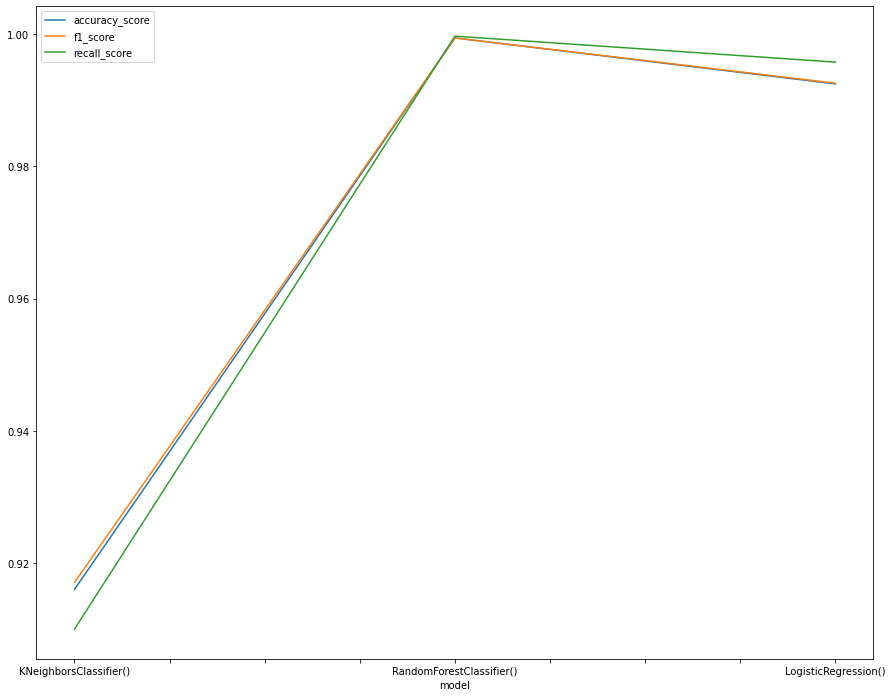

In [51]:
res.index = res.model
res = res.drop(["model"], axis=1)
res.plot(figsize=(15,12))

На данный момент RandomForestClassifier показывает наилучший результат, далее попробуем его сделать еще лучше

# Подбор гиперпараметров

Добитьтся более точной работы модели можно также с помощью побора гиперпараметров, используя GridSearchCV. Он находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров

Для начала преобразуем данные для более корректного и точного определения гиперпараметров

In [79]:
#векторизируем наши данные
vect = CountVectorizer().fit(X_train)
X_train = vect.transform(X_train)
#нормализация
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)

Будем использовать GridSearchCV для каждой модели и покажем следущие результаты:
- `best score` - наилучший результ работы модели во время перекрестной проверки (будет использована метрика 'accuracy')
- `best model` - параметры модели, которая и показала наилучший результат при своей работе

### KNeighborsClassifier

In [80]:
#параметры
model = KNeighborsClassifier()
param_search = { 
    'n_neighbors': [5,10,15,20],
    'weights': ['uniform', 'distance']
}

#GridSearchCV
gsearch = GridSearchCV(estimator=model,  param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [81]:
best_score

0.9593154799231977

In [84]:
best_model

KNeighborsClassifier(weights='distance')

### RandomForestClassifier

In [85]:
#параметры
model = RandomForestClassifier()
param_search = { 
    'n_estimators': [20, 50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth' : [i for i in range(5,15)]
}

#GridSearchCV
gsearch = GridSearchCV(estimator=model, cv=5, param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [86]:
best_score

0.8852556769098143

In [87]:
best_model

RandomForestClassifier(max_depth=14, n_estimators=50)

### LogisticRegression

In [88]:
#параметры
model = LogisticRegression()
param_search = { 
    'penalty': ['l1', 'l2', 'lasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

#GridSearchCV
gsearch = GridSearchCV(estimator=model, cv=5, param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [89]:
best_score

0.9994512191650115

In [90]:
best_model

LogisticRegression(penalty='l1', solver='liblinear')

Далее по полученным гиперпараметрам посмотрим на новые результаты

In [16]:
models = [
    KNeighborsClassifier(weights='distance'),
    RandomForestClassifier(max_depth=14, n_estimators=50),
    LogisticRegression(penalty='l1', solver='liblinear')
]
# result dataframe
res =pd.DataFrame()
for model in models:
    tmp={}
    print(str(model))
    tmp["model"] = str(model)
    # pipeline
    pipe = Pipeline([("vect", CountVectorizer()),("tfidf", TfidfTransformer()),("clf", model)])
    # classification
    text_clf = pipe.fit(X_train, y_train)
    pred = text_clf.predict(X_test)
    # metrics
    print("\taccuracy_score", accuracy_score(pred, y_test))
    print("\tf1_score", f1_score(pred, y_test, average="weighted"))
    print("\trecall_score", recall_score(pred, y_test, average="macro"))
    tmp["accuracy_score"] = accuracy_score(pred, y_test)
    tmp["f1_score"] = f1_score(pred, y_test, average="weighted")
    tmp["recall_score"] = recall_score(pred, y_test, average="macro")
    res = res.append(tmp, ignore_index=True)
    print("<================>")

KNeighborsClassifier(weights='distance')
	accuracy_score 0.9205408690367669
	f1_score 0.9213786372082922
	recall_score 0.9075375624200481
<================>
RandomForestClassifier(max_depth=14, n_estimators=50)
	accuracy_score 0.8602248556669705
	f1_score 0.8882417981265861
	recall_score 0.6534881024510935
<================>
LogisticRegression(penalty='l1', solver='liblinear')
	accuracy_score 0.9979742732705358
	f1_score 0.9979868035374011
	recall_score 0.9994792404024276
<================>


С гиперпараметрами RandomForestClassifier показал результаты хуже чем без них, это у других моделей показатели значительно улучшились. Тем не менее для дальнейшей работы оставим RandomForestClassifier без учета гиперпараметров, так как он показал лучший результат по сравнению с другими моделями

In [15]:
# сохранение выбранной модели
model = Pipeline([("vect", CountVectorizer()),
                  ("tfidf", TfidfTransformer()),
                  ("clf", RandomForestClassifier())])
text_clf = pipe.fit(X_train, y_train)

# Saving as pkl file
pkl_filename = "model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(text_clf, file)

## Вывод:
На данном этапе мы:
- обучили нашу модель на тестовой выборке
- провизуализировали, как работают алгоритмы
- подобрали гиперпараметры, тем самым улучшив результаты работы
- выбрали модель, которая показала наилучший показатель - RandomForestClassifier

---

# Итог:
В ходе работы мы выполнили следующее:
- разбили данные на тренировочную и тестовую выборки
- добавили новые атрибуты
- произвели обучение модели
- обосновали выбор класссификаторов и метрик
- подобрали гиперпараметры
- сравнили, какая модель справляется лучше и при каких условиях